In [8]:
# =========================
# CELL 0: COMMON SETUP
# =========================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

# Scaling
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Create sequences
#Use the previous 60 days of stock prices to predict the price of the next day



X_train, y_train = [], []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0]) #Index: 0 → 59   → used as input
    y_train.append(training_set_scaled[i, 0]) #Index: 60       → predicted value

X_train = np.array(X_train)
y_train = np.array(y_train)

# Dataset class
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [9]:
# =========================
# CELL : CONV-LSTM (1D)
# =========================
class ConvLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.lstm = nn.LSTM(input_size=16, hidden_size=60,
                            num_layers=2, batch_first=True)
        self.fc = nn.Linear(60, 1)

    def forward(self, x):
        # x: (batch, seq, 1)
        x = x.permute(0, 2, 1)          # (batch, 1, seq)
        x = self.conv1d(x)              # (batch, 16, seq-2)
        x = x.permute(0, 2, 1)          # (batch, seq-2, 16)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = ConvLSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 120
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.006357
Epoch 10, Loss: 0.000419
Epoch 20, Loss: 0.000357
Epoch 30, Loss: 0.000609
Epoch 40, Loss: 0.000167
Epoch 50, Loss: 0.000321
Epoch 60, Loss: 0.000420
Epoch 70, Loss: 0.000331
Epoch 80, Loss: 0.000206
Epoch 90, Loss: 0.000112
Epoch 100, Loss: 0.000350
Epoch 110, Loss: 0.000402


In [10]:
# =========================
# EVALUATION: TEST SET
# =========================

# Load test data
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Combine train + test for sequence creation
dataset_total = pd.concat(
    (dataset_train['Open'], dataset_test['Open']), axis=0
).values.reshape(-1, 1)

# Scale
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:]
inputs = sc.transform(inputs)

# Create test sequences
X_test = []
for i in range(60, 60 + len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Prediction
model.eval()
with torch.no_grad():
    predicted_stock_price = model(X_test).cpu().numpy()

# Inverse scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [11]:
import pandas as pd

# After predicting stock prices:

# Create a DataFrame with both real and predicted prices
df_comparison = pd.DataFrame({'Real Stock Price': real_stock_price.reshape(len(real_stock_price)),
                             'Predicted Stock Price': predicted_stock_price.reshape(len(predicted_stock_price))})

# Display the DataFrame
print(df_comparison)

    Real Stock Price  Predicted Stock Price
0             778.81             787.367798
1             788.36             782.846069
2             786.08             793.000793
3             795.26             789.290039
4             806.40             798.774597
5             807.86             807.315552
6             805.00             808.886292
7             807.14             805.970459
8             807.48             808.176331
9             807.08             808.760803
10            805.81             808.973816
11            805.12             807.789062
12            806.91             807.466431
13            807.25             809.231323
14            822.30             809.492859
15            829.62             823.420105
16            837.81             828.755859
17            834.71             836.504517
18            814.66             832.629333
19            796.86             815.423584


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


RMSE : 7.880
MAE  : 5.866
R²   : 0.714


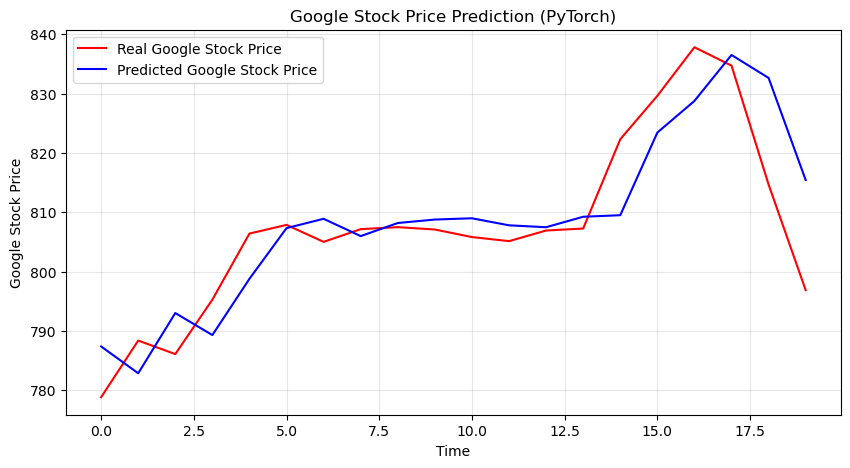

In [13]:
# =========================
# VISUALIZATION
# =========================
plt.figure(figsize=(10,5))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
